In [ ]:
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pandas as pd
import collections
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/rock-paper-scissors.zip'
extract_path = '/content/rps_data'

#here we extract the data set
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("unzipped the dataset")

unzipped the dataset


In [ ]:
#student id
seed = 390720

#this loads the traning dataset and we set images to 160 by 160 and batches of 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/rps_data/Rock-Paper-Scissors/train',
    seed=seed,
    image_size=(160, 160),
    batch_size=32
)
#this loads the validates dataset and we set images to 160 by 160 and batches of 32
val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/rps_data/Rock-Paper-Scissors/validation',
    seed=seed,
    image_size=(160, 160),
    batch_size=32
)
#this loads the test dataset and we set images to 160 by 160 and batches of 32
test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/rps_data/Rock-Paper-Scissors/test',
    seed=seed,
    image_size=(160, 160),
    batch_size=32
)

#here we set class name
class_names = train_ds.class_names
val_ds.class_names = class_names
test_ds.class_names = class_names


#this is ment to count how many classes
def count_classes(ds, name):
    all_labels = []
    for _, labels in ds.unbatch():
        all_labels.append(labels.numpy())
    print(f"{name} class distribution:", collections.Counter(all_labels))

count_classes(train_ds, "Train set")
count_classes(val_ds, "Validation set")
count_classes(test_ds, "Test set")

Found 2520 files belonging to 3 classes.
Found 33 files belonging to 3 classes.
Found 372 files belonging to 3 classes.
Train set class distribution: Counter({np.int32(0): 840, np.int32(2): 840, np.int32(1): 840})
Validation set class distribution: Counter({np.int32(2): 11, np.int32(1): 11, np.int32(0): 11})
Test set class distribution: Counter({np.int32(0): 124, np.int32(2): 124, np.int32(1): 124})


In [ ]:
#here we give the class names to the validation and test sets
class_names = train_ds.class_names
val_ds.class_names = train_ds.class_names
test_ds.class_names = train_ds.class_names

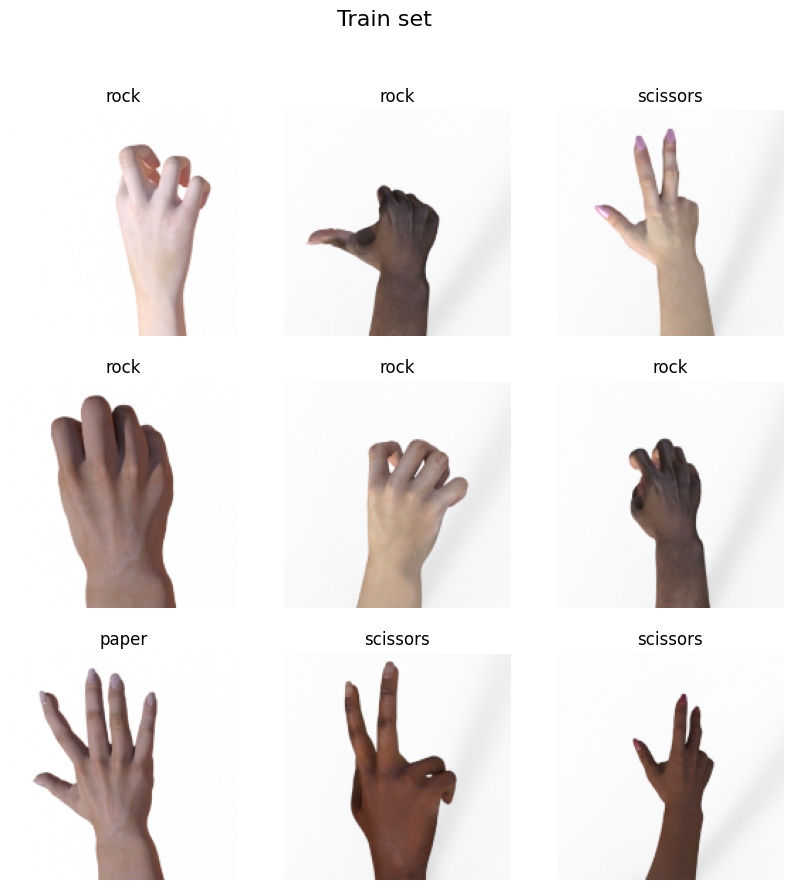

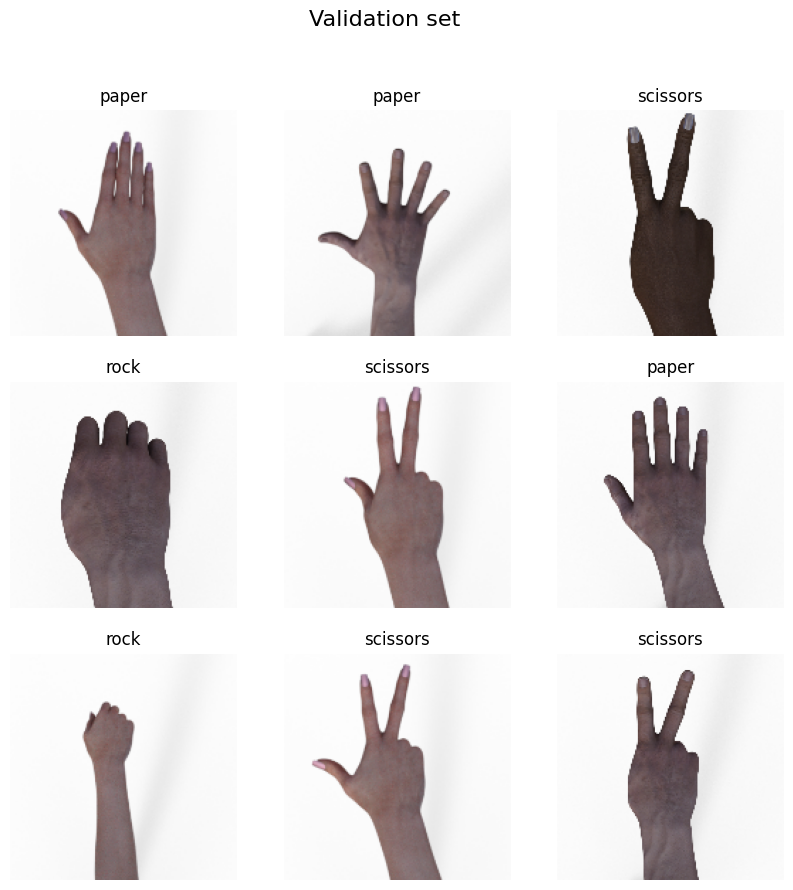

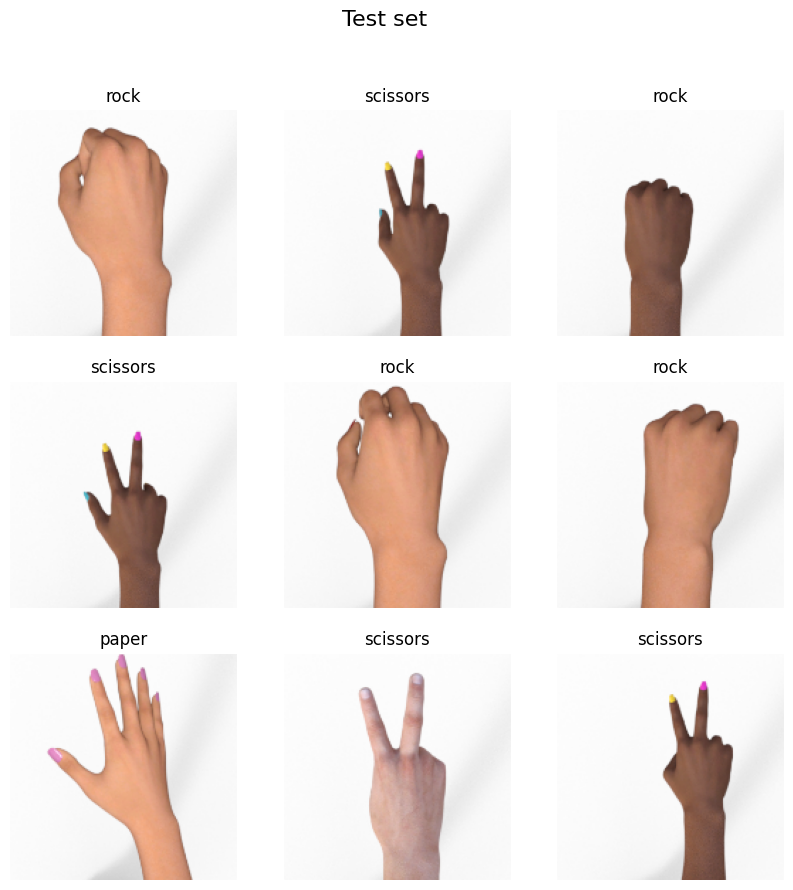

In [ ]:
#this function plots the images from the dataset
def image_plot(dataset, title):
    plt.figure(figsize=(10, 10))
    images, labels = next(iter(dataset))
    #this plots 9 images 3x3
    for i in range(9):
        if i < len(images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            #this checks if the dataset has class names
            if hasattr(dataset, 'class_names'):
                class_name = dataset.class_names[labels[i]]
            else:
                class_name = "Class " + str(labels[i])

            plt.title(class_name)
            plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.show()

#this plots the images from the training, validation, and test sets
image_plot(train_ds, "Train set")
image_plot(val_ds, "Validation set")
image_plot(test_ds, "Test set")

In [ ]:
#here we autotune the dataset
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#there are 3 classes rock paper and scissors
num_classes = 3

In [ ]:
#this function builds the cnn model
def build_cnn(input_shape=(160, 160, 3)):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.Input(shape=input_shape))
    model.add(layers.Rescaling(1./255))

    #this is the first convolutional block
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.BatchNormalization())

    #this is the second convolutional block
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.BatchNormalization())

    #this is the third convolutional block
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.BatchNormalization())

    #this is the fully connected block
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


In [ ]:
#this function builds a transfer learning model
def build_transfer_learning_model(base_model_name='vgg16', input_shape=(160, 160, 3)):
    #this creates data augmentation to prevent overfitting
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ])

    #this loads model based of name
    if base_model_name.lower() == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name.lower() == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unsupported model. Use 'vgg16' or 'resnet50'")

    base_model.trainable = False

    #builts model using functunal api
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    #this creates outputlayer with 3 classes
    outputs = layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
#this function evaluates and trains the model
def train_and_evaluate(model, train_ds, val_ds, test_ds, epochs=10, model_name="Model"):
    #this is the compiler
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )


    model.summary()


    start_time = time.time()
    history = model.fit(
    train_ds,
    validation_data=val_ds,
    #here we set the traing epochs to 10 you could set it to more for better results as if model doesnt improve it will stop
    epochs=10,
    callbacks=[early_stop]
)

    #this measures the time trained
    training_time = time.time() - start_time
    print(f"Training time for {model_name}: {training_time:.2f} seconds")


    start_time = time.time()
    test_loss, test_acc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    print(f"Inference time for {model_name}: {inference_time:.2f} seconds")
    print(f"Test accuracy: {test_acc:.4f}")

    #this plots the history
    plt.figure(figsize=(12, 4))

    #this plots the training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    #this plots the training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history, test_acc, training_time, inference_time


--- Training RGB CNN Model ---


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,259 (25.36 MB)

 Trainable params: 6,647,811 (25.36 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.6945 - loss: 4.9932 - val_accuracy: 0.3333 - val_loss: 2.5258
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.9596 - loss: 0.1157 - val_accuracy: 0.3333 - val_loss: 5.4597
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9770 - loss: 0.0578 - val_accuracy: 0.3333 - val_loss: 8.7204
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.9824 - loss: 0.0438 - val_accuracy: 0.3333 - val_loss: 8.8673
Training time for RGB CNN: 749.49 seconds
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 648ms/step - accuracy: 0.3299 - loss: 2.3846
Inference time for RGB CNN: 10.24 seconds
Test accuracy: 0.3333


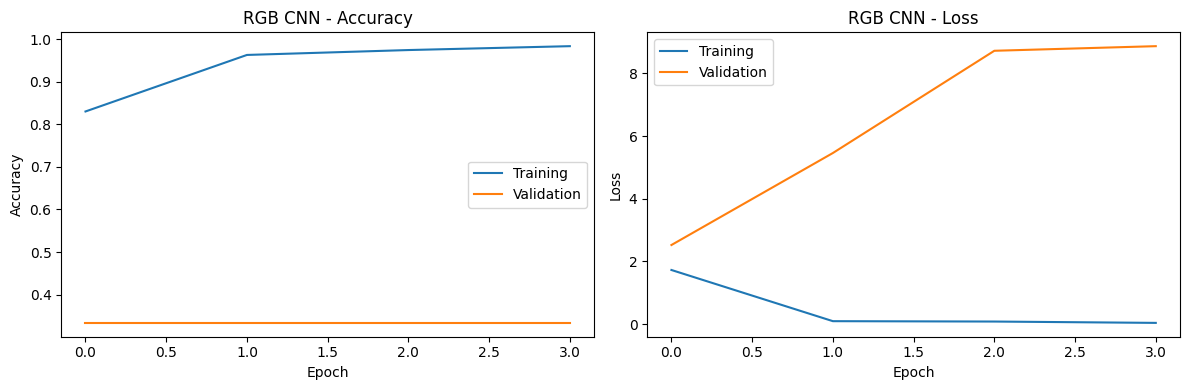

In [ ]:
#here we create and train cnn rgb model
print("\n--- Training RGB CNN Model ---")
rgb_cnn_model = build_cnn(input_shape=(160, 160, 3))
rgb_cnn_model, rgb_history, rgb_acc, rgb_train_time, rgb_infer_time = train_and_evaluate(
    rgb_cnn_model, train_ds, val_ds, test_ds, epochs=10, model_name="RGB CNN"
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 496ms/step


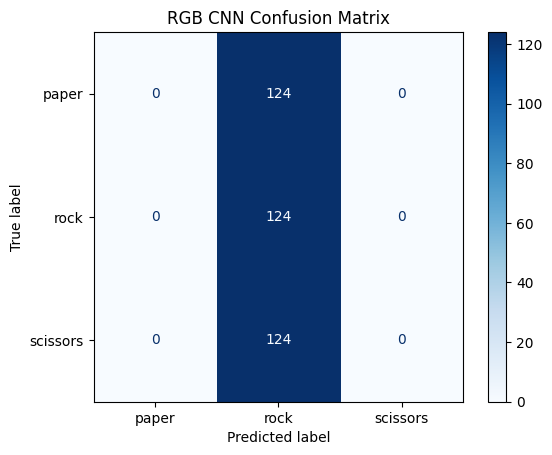

In [ ]:
#this creates a confusion matrix to visualize model predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(rgb_cnn_model.predict(test_ds), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("RGB CNN Confusion Matrix")
plt.show()

In [ ]:
#this function creates a grayscale version of the dataset
def create_grayscale_dataset(original_ds, image_size=(160, 160), batch_size=32):
    #this converts RGB images to grayscale
    def convert_to_grayscale(image, label):
        image = tf.image.rgb_to_grayscale(image)
        #this repeats the grayscale channel 3 times to maintain shape
        image = tf.repeat(image, 3, axis=-1)
        return image, label

    #this applies the conversion to the dataset
    grayscale_ds = original_ds.map(convert_to_grayscale)

    #this copies class_names from original dataset
    if hasattr(original_ds, 'class_names'):
        grayscale_ds.class_names = original_ds.class_names

    return grayscale_ds

#this function plots the images from the dataset
def image_plot(dataset, title):
    plt.figure(figsize=(10, 10))
    images, labels = next(iter(dataset))
    #this plots 9 images 3x3
    for i in range(9):
        if i < len(images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            #this gets the label index as an integer
            label_idx = int(labels[i].numpy())

            #this maps indices to class names
            class_mapping = {0: "rock", 1: "paper", 2: "scissors"}
            class_name = class_mapping.get(label_idx, f"Class {label_idx}")

            plt.title(class_name)
            plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.show()

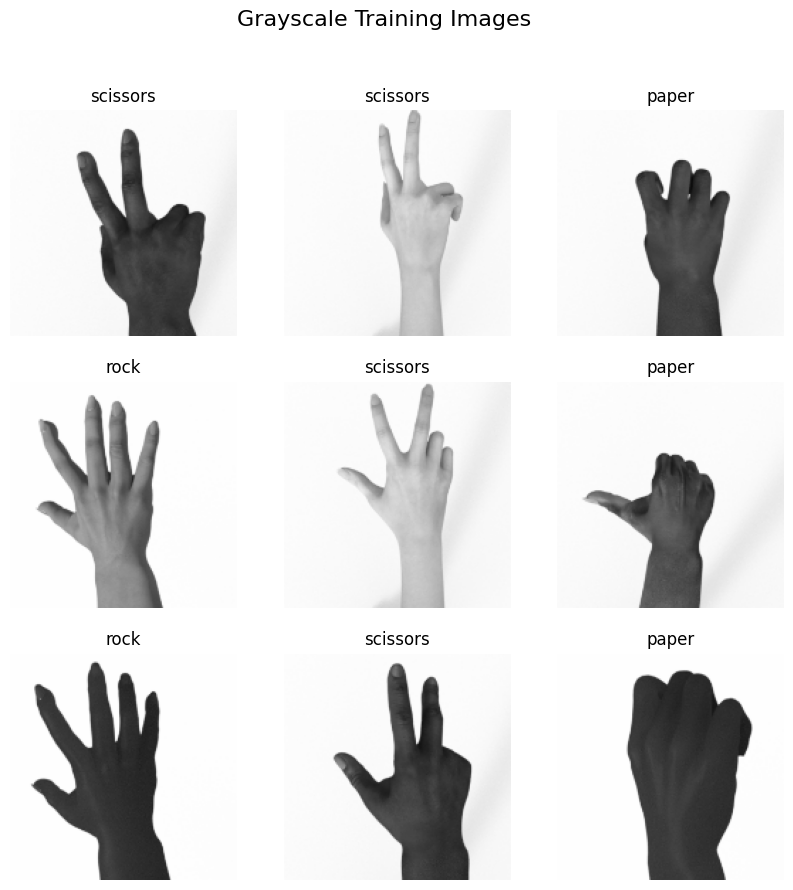


--- Training Grayscale CNN Model ---


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,259 (25.36 MB)

 Trainable params: 6,647,811 (25.36 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.6469 - loss: 5.9205 - val_accuracy: 0.3333 - val_loss: 3.8678
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9588 - loss: 0.1206 - val_accuracy: 0.3333 - val_loss: 7.5338
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.9643 - loss: 0.1032 - val_accuracy: 0.3333 - val_loss: 7.6195
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.9766 - loss: 0.0629 - val_accuracy: 0.3333 - val_loss: 9.0656
Training time for Grayscale CNN: 747.90 seconds
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 503ms/step - accuracy: 0.3299 - loss: 4.1924
Inference time for Grayscale CNN: 10.27 seconds
Test accuracy: 0.3333


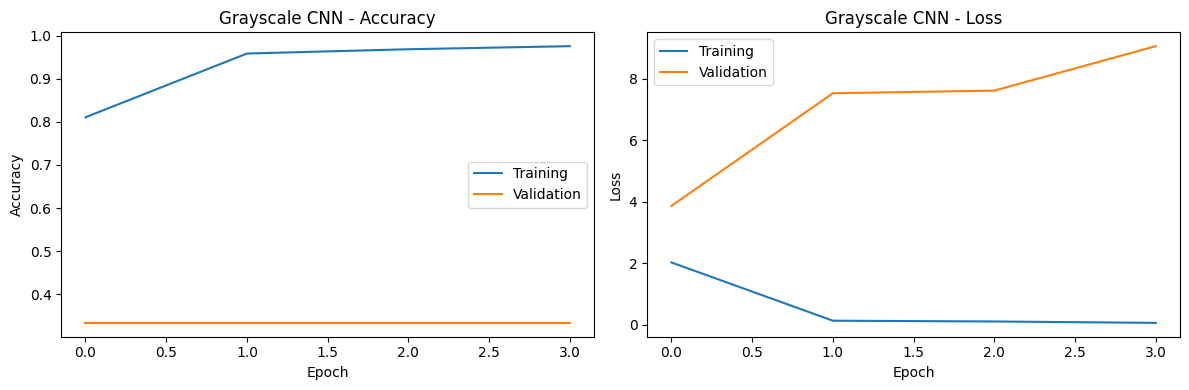

In [ ]:
#this creates grayscale versions of all datasets
train_ds_gray = create_grayscale_dataset(train_ds)
val_ds_gray = create_grayscale_dataset(val_ds)
test_ds_gray = create_grayscale_dataset(test_ds)

#this displays sample grayscale images
image_plot(train_ds_gray, "Grayscale Training Images")

#this builds and trains the grayscale cnn model
print("\n--- Training Grayscale CNN Model ---")
gray_cnn_model = build_cnn(input_shape=(160, 160, 3))
gray_cnn_model, gray_history, gray_acc, gray_train_time, gray_infer_time = train_and_evaluate(
    gray_cnn_model, train_ds_gray, val_ds_gray, test_ds_gray, epochs=10, model_name="Grayscale CNN"
)


--- Training VGG16 Transfer Learning Model ---


Model: "functional_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 841s 11s/step - accuracy: 0.5419 - loss: 0.9863 - val_accuracy: 0.6667 - val_loss: 0.6570
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 850s 10s/step - accuracy: 0.9205 - loss: 0.3885 - val_accuracy: 0.7273 - val_loss: 0.5771
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 830s 11s/step - accuracy: 0.9583 - loss: 0.2095 - val_accuracy: 0.8485 - val_loss: 0.4016
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 826s 10s/step - accuracy: 0.9736 - loss: 0.1344 - val_accuracy: 0.8485 - val_loss: 0.3359
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 827s 10s/step - accuracy: 0.9825 - loss: 0.1082 - val_accuracy: 0.8485 - val_loss: 0.3916
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 860s 10s/step - accuracy: 0.9849 - loss: 0.0746 - val_accuracy: 0.8485 - val_loss: 0.3028
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 827s 10s/step - accuracy: 0.9879 - loss: 0.0660 - val_accuracy: 0.8788 - val_loss: 0.3209
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 821s 10s/step - accuracy: 0.9912 - loss: 0.0487 - val_accuracy: 0.

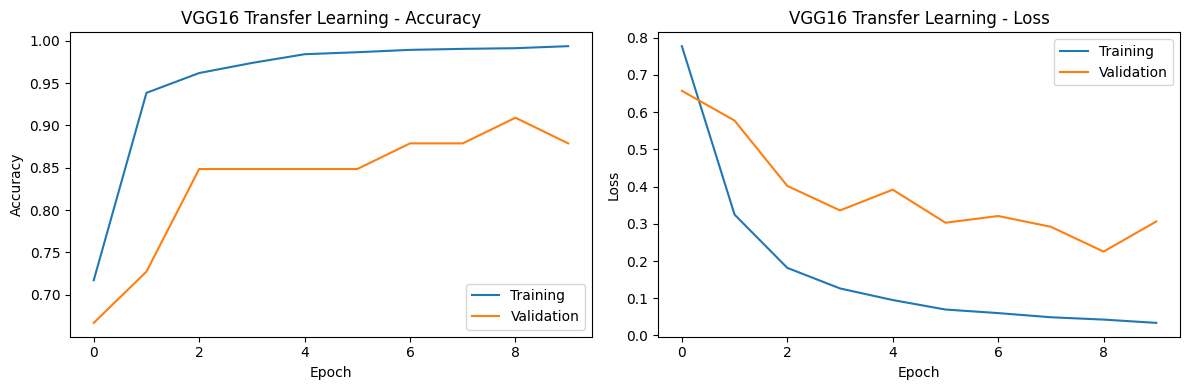

In [55]:
#this builds and trains the vgg16 transfer learning model
print("\n--- Training VGG16 Transfer Learning Model ---")
vgg_model = build_transfer_learning_model('vgg16', input_shape=(160, 160, 3))
vgg_model, vgg_history, vgg_acc, vgg_train_time, vgg_infer_time = train_and_evaluate(
    vgg_model, train_ds, val_ds, test_ds, epochs=10, model_name="VGG16 Transfer Learning"
)


--- Training ResNet50 Transfer Learning Model ---


Model: "functional_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.3880 - loss: 1.1538 - val_accuracy: 0.5152 - val_loss: 0.9899
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.5695 - loss: 0.9227 - val_accuracy: 0.6061 - val_loss: 0.8767
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.6611 - loss: 0.8096 - val_accuracy: 0.6364 - val_loss: 0.7736
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.7151 - loss: 0.7042 - val_accuracy: 0.6061 - val_loss: 0.7422
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.7797 - loss: 0.6192 - val_accuracy: 0.6970 - val_loss: 0.6682
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.8046 - loss: 0.5502 - val_accuracy: 0.6970 - val_loss: 0.6701
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.8225 - loss: 0.4946 - val_accuracy: 0.6061 - val_loss: 0.7664
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.8384 - loss: 0.4645 - val_accuracy: 0.7576 - v

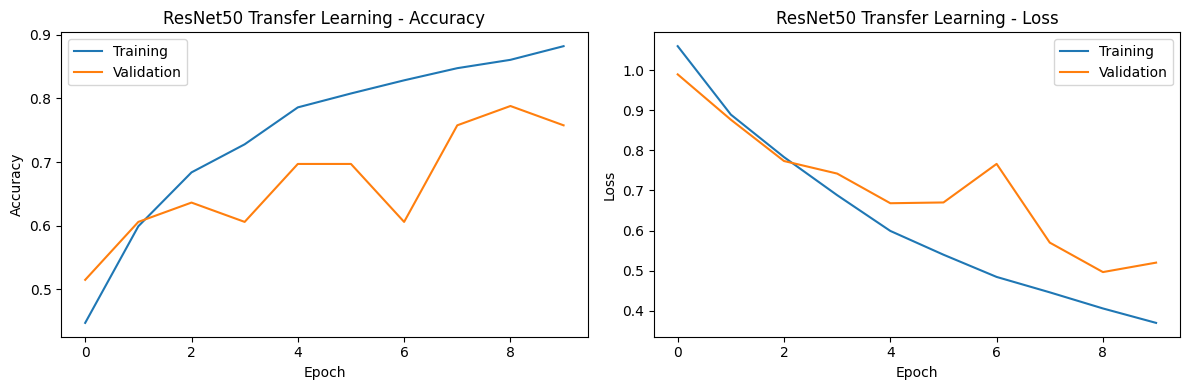

In [56]:
#this builds and trains the resnet50 transfer learning model
print("\n--- Training ResNet50 Transfer Learning Model ---")
resnet_model = build_transfer_learning_model('resnet50', input_shape=(160, 160, 3))
resnet_model, resnet_history, resnet_acc, resnet_train_time, resnet_infer_time = train_and_evaluate(
    resnet_model, train_ds, val_ds, test_ds, epochs=10, model_name="ResNet50 Transfer Learning"
)

In [ ]:
#here we compair the models
models_comparison = {
    "RGB CNN": {
        "Test Accuracy": rgb_acc,
        "Training Time (s)": rgb_train_time,
        "Inference Time (s)": rgb_infer_time
    },
    "Grayscale CNN": {
        "Test Accuracy": gray_acc,
        "Training Time (s)": gray_train_time,
        "Inference Time (s)": gray_infer_time
    },
    "VGG16 Transfer Learning": {
        "Test Accuracy": vgg_acc,
        "Training Time (s)": vgg_train_time,
        "Inference Time (s)": vgg_infer_time
    },
    "ResNet50 Transfer Learning": {
        "Test Accuracy": resnet_acc,
        "Training Time (s)": resnet_train_time,
        "Inference Time (s)": resnet_infer_time
    }
}

#this creates a dataframe to compare all model results
comparison_df = pd.DataFrame(models_comparison).T
print("\n--- Model Comparison ---")
print(comparison_df)

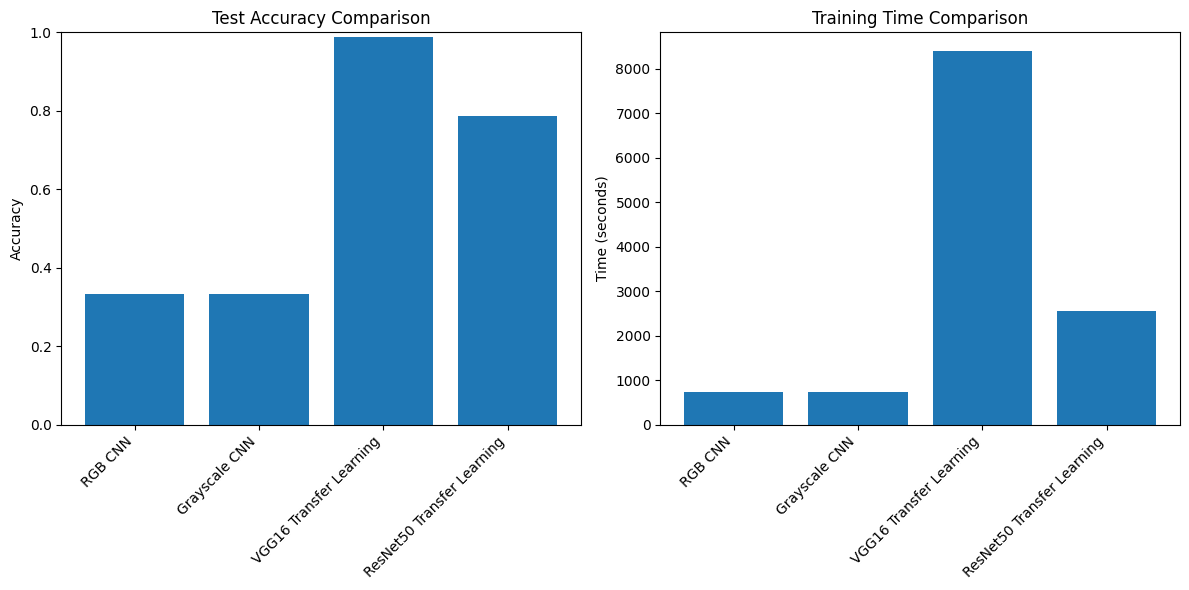


Best model based on accuracy: VGG16 Transfer Learning


In [58]:
#this visualizes the model comparison results
plt.figure(figsize=(12, 6))

#this plots the accuracy comparison
plt.subplot(1, 2, 1)
plt.bar(comparison_df.index, comparison_df["Test Accuracy"])
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

#this plots the training time comparison
plt.subplot(1, 2, 2)
plt.bar(comparison_df.index, comparison_df["Training Time (s)"])
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#this finds the best model based on accuracy
best_model_name = comparison_df["Test Accuracy"].idxmax()
print(f"\nBest model based on accuracy: {best_model_name}")

#this selects the best model for further use
if best_model_name == "RGB CNN":
    best_model = rgb_cnn_model
elif best_model_name == "Grayscale CNN":
    best_model = gray_cnn_model
elif best_model_name == "VGG16 Transfer Learning":
    best_model = vgg_model
else:
    best_model = resnet_model


--- Testing with Custom Images ---
Class names used for prediction: ['rock', 'paper', 'scissors']
Please upload images of rock, paper, scissors gestures:


Saving paper.jpg to paper.jpg
Saving scissors.jpg to scissors (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Raw prediction for paper.jpg: [1.9999797e-04 9.9966443e-01 1.3559942e-04]
Predicted index: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
Raw prediction for scissors (1).jpg: [0.02999518 0.37885085 0.5911539 ]
Predicted index: 2


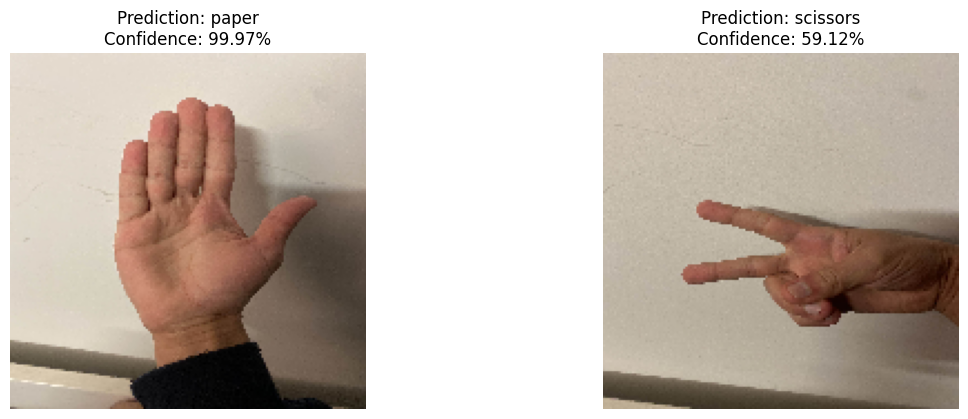


Simulating a Rock-Paper-Scissors game with the first two images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Player 1 shows: paper
Player 2 shows: scissors
Player 2 wins!


In [61]:
#this tests the best model with custom images
print("\n--- Testing with Custom Images ---")

#this prints the class names for verification
print("Class names used for prediction:", class_names)

#this defines class names explicitly if needed
class_names = ['rock', 'paper', 'scissors']

#this function tests the model with user-uploaded images
def test_custom_images(model, class_names, image_size=(160, 160)):
    #this uploads custom images
    from google.colab import files

    print("Please upload images of rock, paper, scissors gestures:")
    uploaded = files.upload()

    plt.figure(figsize=(12, 8))

    #this processes each uploaded image
    for i, (filename, content) in enumerate(uploaded.items()):
        #this saves the image temporarily
        with open(filename, 'wb') as f:
            f.write(content)

        #this loads and preprocesses the image
        img = tf.keras.utils.load_img(
            filename,
            target_size=image_size
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        #this makes a prediction
        predictions = model.predict(img_array)

        #this shows the raw prediction values
        print(f"Raw prediction for {filename}:", predictions[0])

        #this gets the predicted class index
        pred_index = np.argmax(predictions[0])
        print(f"Predicted index: {pred_index}")

        #this maps the index to class name
        if pred_index < len(class_names):
            predicted_class = class_names[pred_index]
        else:
            predicted_class = f"Unknown (index {pred_index})"

        confidence = 100 * np.max(predictions[0])

        #this displays the image and prediction
        plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    #this determines the winner in rock-paper-scissors
    def determine_winner(gesture1, gesture2):
        if gesture1 == gesture2:
            return "It's a tie!"
        elif (gesture1 == "rock" and gesture2 == "scissors") or \
             (gesture1 == "paper" and gesture2 == "rock") or \
             (gesture1 == "scissors" and gesture2 == "paper"):
            return "Player 1 wins!"
        else:
            return "Player 2 wins!"

    #this simulates a game with two uploaded images
    if len(uploaded) >= 2:
        print("\nSimulating a Rock-Paper-Scissors game with the first two images:")

        #this gets filenames of first two images
        filenames = list(uploaded.keys())

        #this processes the first image
        img1 = tf.keras.utils.load_img(filenames[0], target_size=image_size)
        img1_array = tf.keras.utils.img_to_array(img1)
        img1_array = tf.expand_dims(img1_array, 0)
        pred1 = model.predict(img1_array)
        pred1_index = np.argmax(pred1[0])
        gesture1 = class_names[pred1_index] if pred1_index < len(class_names) else f"Unknown (index {pred1_index})"

        #this processes the second image
        img2 = tf.keras.utils.load_img(filenames[1], target_size=image_size)
        img2_array = tf.keras.utils.img_to_array(img2)
        img2_array = tf.expand_dims(img2_array, 0)
        pred2 = model.predict(img2_array)
        pred2_index = np.argmax(pred2[0])
        gesture2 = class_names[pred2_index] if pred2_index < len(class_names) else f"Unknown (index {pred2_index})"

        #this determines and displays the winner
        print(f"Player 1 shows: {gesture1}")
        print(f"Player 2 shows: {gesture2}")
        print(determine_winner(gesture1, gesture2))

#this calls the function with the best model
test_custom_images(best_model, class_names, image_size=(160, 160))

In [60]:
#this saves the best model to Google Drive
best_model.save(f'/content/drive/MyDrive/best_rps_model_{best_model_name.replace(" ", "_").lower()}.h5')
print(f"Best model ({best_model_name}) saved to Google Drive")

Best model (VGG16 Transfer Learning) saved to Google Drive
